## **TASK 01: DATA COLLECTION**

### Using X (Twitter) API To Collect Trending Tweets

In [1]:
# Importing libraries

import pandas as pd
import tweepy

In [2]:
# X API Bearer token

BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAEp2xgEAAAAAbQpZG%2BnyLSiSmmLd5Fn%2B9OEbrfI%3DUEZoRYUqw2HB1PhpMSoRV31X0dokJMmLAvZ89MuNFy3FwU8EAp"

# Authenticating with bearer token

client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Defining the query and number of tweets to fetch

query = "#trending -is:retweet lang:en"
max_results = 100  # 100 because that is the maximum tweet count for a month

# Fetching tweets

response = client.search_recent_tweets(query=query, max_results=max_results, tweet_fields=["created_at", "text", "author_id"])

# Parsing tweet data

tweet_data = []
for tweet in response.data:
    tweet_data.append({
        "Author ID": tweet.author_id,
        "Text": tweet.text,
        "Created At": tweet.created_at
    })

# Saving the data to a csv file

df = pd.DataFrame(tweet_data)
df.to_csv("trending_tweets.csv", index=False)
print("Tweets saved as trending_tweets.csv")

Tweets saved as trending_tweets.csv


### Using News API To Collect News Articles

In [4]:
# Importing necessary libraries

import requests

In [5]:
# NewsAPI Key and URL

API_KEY = "82603e5cb7c24fd39615b1f4d1f8e085"
URL = "https://newsapi.org/v2/everything"

# Setting parameters

query = "world news"  # Query for news
page_size = 100  # 100 because it is the maximum count with free plan for this API
language = "en"  # Language set to English to only get English articles
sort_by = "publishedAt"  # Sorting articles by date

# Setting API request parameters for fetching articles

params = {
    "q": query,
    "pageSize": page_size,
    "apiKey": API_KEY,
    "language": language,
    "sortBy": sort_by
}

# Sending API request

response = requests.get(URL, params=params)

# Checking for any errors

if response.status_code != 200:
    print(f"Error: {response.status_code}, {response.text}")
else:
    print("Fetching articles...")
    data = response.json()

    # Extracting articles

    articles = data.get("articles", [])
    article_list = []
    for article in articles:
        article_list.append({
            "Title": article["title"],
            "Content": article["content"],
            "Description": article["description"],
            "Source": article["source"]["name"],
            "Published At": article["publishedAt"],
            "URL": article["url"]
        })

    # Converting to a Pandas DataFrame

    df = pd.DataFrame(article_list)

    # Saving data as a CSV file

    df.to_csv("world_news_100_articles.csv", index=False)
    print(f"Saved {len(df)} articles to 'world_news_100_articles.csv'.")

Fetching articles...
Saved 100 articles to 'world_news_100_articles.csv'.


### Using Web Scraping To Collect Reddit Posts

Web scraping Reddit using Python was not possible due to all the GET requests been blocked by the targeted website. Even with headless browsing using Python's Selenium library was not possible because of the unknown error 'Cannot find Chrome binary Stacktrace' which happens because Selenium library cannot locate the Chrome binary which is the executable file for Google Chrome. Even with updating Google Chrome and matching ChromeDriver with Chrome version was not able to fix this error.

So, in order to web scrap Reddit R programming language has been used instead of Python. R can web scrap more efficiently with clearly zero errors due to it's dedicated libraries. Following is the R code used to do this task. Original R code, R console output, RData and the csv file will be submitted as deliverables.



```
# Loading necessary libraries

library(rvest)
library(dplyr)
library(stringr)

# Base URL for r/worldnews on old Reddit
# Using 'old' version of reddit because it has a much cleaner HTML structure making it easy to web scrap than the modern UI

base_url <- "https://old.reddit.com/r/worldnews/?count="
increment <- 25  # Number of posts per page
num_pages <- 10   # Number of pages to scrape
current_count <- 0  # Tracking the pagination count

# File paths to save scraped data to a CSV file and console output

csv_file_path <- "F:/NSBM Final Year/Natural Language Processing/worldnews_reddit_posts.csv"
console_log_path <- "F:/NSBM Final Year/Natural Language Processing/console_output.txt"

# Initializing an empty data frame to store posts

posts_data <- data.frame(
  Title = character(),
  Posted_By = character(),
  Created_At = character(),
  stringsAsFactors = FALSE
)

# Start logging console output to a file

sink(console_log_path, split = TRUE)

# Scraping Loop

for (page in 1:num_pages) {
  # Constructing the URL for the current page
  url <- paste0(base_url, current_count)
  cat("Scraping page:", page, "URL:", url, "\n")
  
  # Reading the webpage content
  
  webpage <- tryCatch({
    read_html(url)
  }, error = function(e) {
    cat("Error reading page:", e$message, "\n")
    return(NULL)
  })
  
  if (is.null(webpage)) next  # Skip if the page fails to load
  
  # Extracting post containers
  
  posts <- webpage %>% html_nodes(".thing")
  
  # Extracting details from each post
  
  for (post in posts) {
    tryCatch({
      title <- post %>% html_node(".title .title") %>% html_text(trim = TRUE)
      posted_by <- post %>% html_node(".author") %>% html_text(trim = TRUE)
      created_at <- post %>% html_node("time") %>% html_attr("title")
      
      # Handling missing data with NaN
      
      title <- ifelse(is.na(title) | title == "", "NaN", title)
      posted_by <- ifelse(is.na(posted_by) | posted_by == "", "NaN", posted_by)
      created_at <- ifelse(is.na(created_at) | created_at == "", "NaN", created_at)
      
      # Appending the post data to the Dataframe
      
      posts_data <- posts_data %>%
        add_row(
          Title = title,
          Posted_By = posted_by,
          Created_At = created_at
        )
    }, error = function(e) {
      cat("Error extracting post details:", e$message, "\n")
    })
  }
  
  # Updating the pagination count
  
  current_count <- current_count + increment
}


# Saving the scraped data to a CSV file

write.csv(posts_data, csv_file_path, row.names = FALSE)

# Completion message

cat("\nScraping completed. Saved", nrow(posts_data), "posts to", csv_file_path, "\n")

# Stop logging console output

sink()
```



## **TASK 02: DATA PREPROCESSING AND TOKENIZATION**

### Preprocessing and Tokenizing 'trending_tweets.csv'

In [22]:
# Importing necessary libraries

import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [24]:
# Downloading necessary NLTK resources

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
# Loading the dataset

file_path = '/content/trending_tweets.csv'
trending_tweets = pd.read_csv(file_path)

# Initializing tools

stop_words = set(stopwords.words('english'))
lemmatizer1 = WordNetLemmatizer()

# Preprocessing with for loops

processed_texts1 = []
bigrams_list1 = []

for text in trending_tweets['Text']:

    # Lowercase text

    text = text.lower()

    # Removing special characters and punctuation

    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenizing text

    tokens = word_tokenize(text)

    # Removing stop words and lemmatizing

    processed_tokens1 = [lemmatizer1.lemmatize(word) for word in tokens if word not in stop_words]
    processed_texts1.append(processed_tokens1)

    # Creating bigrams

    bigrams1 = list(nltk.ngrams(processed_tokens1, 2))
    bigrams_list1.append(bigrams1)

# Adding  preprocessed data back to the DataFrame

trending_tweets['Processed Text'] = processed_texts1
trending_tweets['Bigrams'] = bigrams_list1

# Saving the preprocessed dataset to a new CSV

processed_file_path = 'preprocessed_trending_tweets.csv'
trending_tweets.to_csv(processed_file_path, index=False)

print(f"Processed data saved to {processed_file_path}")

print(trending_tweets[['Text', 'Processed Text', 'Bigrams']].head())

Processed data saved to preprocessed_trending_tweets.csv
                                                Text  \
0  LET GET PAID AGAIN TONIGHT 🤑🤑\nTAP IN THE LINK...   
1  #Gravita #Chart \n\nCheck #trending #chartpatt...   
2  Get inspired ✨\n\nPhoto\n#trending #digital #p...   
3  Andrew Tate police win bid to seize more than ...   
4  Mass grave of babies is found in British cemet...   

                                      Processed Text  \
0  [let, get, paid, tonight, 🤑🤑, tap, link, get, ...   
1  [gravita, chart, check, trending, chartpattern...   
2  [get, inspired, ✨, photo, trending, digital, p...   
3  [andrew, tate, police, win, bid, seize, £2m, i...   
4  [mass, grave, baby, found, british, cemetery, ...   

                                             Bigrams  
0  [(let, get), (get, paid), (paid, tonight), (to...  
1  [(gravita, chart), (chart, check), (check, tre...  
2  [(get, inspired), (inspired, ✨), (✨, photo), (...  
3  [(andrew, tate), (tate, police), (police, win)

## Preprocessing and Tokenizing 'worldnews_100_articles.csv'

In [29]:
# Loading the dataset

file_path = '/content/worldnews_100_articles.csv'
worldnews_articles = pd.read_csv(file_path)

# Counting rows where any column contains '[Removed]'

removed_rows_count = worldnews_articles.isin(['[Removed]']).any(axis=1).sum()

print(f"Total number of rows with '[Removed]' content: {removed_rows_count}")

Total number of rows with '[Removed]' content: 18


In [31]:
# Removing 18 rows which contains '[Removed]'

cleaned_worldnews_articles = worldnews_articles[~worldnews_articles.isin(['[Removed]']).any(axis=1)]

print(f"Total number of rows after removing '[Removed]' content: {len(cleaned_worldnews_articles)}")
print(cleaned_worldnews_articles)

Total number of rows after removing '[Removed]' content: 82
                                                Title  \
1   Quartararo impressed by change in Yamaha's men...   
4   Why is tech giant SoftBank investing over $100...   
6                               The sun shows the way   
7   The dangers of industrialisation: why we need ...   
9          CosmoBlue Media acquires Caracol TV titles   
..                                                ...   
95  UBS AM a distinct business unit of UBS ASSET M...   
96  Wolverine Trading LLC Takes Position in Soho H...   
97  “No Way Those Kids Are Theirs”: Outrage After ...   
98         Pavlo Golub: PGDay/MED 2024 Napoli Edition   
99  Missile test, first Marine redeployment give U...   

                                              Content  \
1   Fabio Quartararo has said he was impressed by ...   
4   Author of the article:\r\nArticle content\r\nB...   
6   Rashid Vally, the visionary behind South Afric...   
7   <ol><li>Richard Smith, 

In [35]:
# Initializing tools

stop_words = set(stopwords.words('english'))
lemmatizer2 = WordNetLemmatizer()

# Preprocessing with for loops

processed_texts2 = []
bigrams_list2 = []

# Processing the "Content" column of the cleaned dataset

for text in cleaned_worldnews_articles['Content']:

    # Lowercase text

    text = text.lower()

    # Removing any special characters and punctuation

    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenizing text

    tokens = word_tokenize(text)

    # Removing stop words and lemmatizing

    processed_tokens2 = [lemmatizer2.lemmatize(word) for word in tokens if word not in stop_words]
    processed_texts2.append(processed_tokens2)

    # Creating bigrams

    bigrams2 = list(nltk.ngrams(processed_tokens2, 2))
    bigrams_list2.append(bigrams2)

# Adding processed data back to the DataFrame

cleaned_worldnews_articles['Processed Text'] = processed_texts2
cleaned_worldnews_articles['Bigrams'] = bigrams_list2

# Saving the preprocessed dataset to a new file

preprocessed_file_path = 'preprocessed_cleaned_worldnews_100_articles.csv'
cleaned_worldnews_articles.to_csv(preprocessed_file_path, index=False)

print(cleaned_worldnews_articles[['Content', 'Processed Text', 'Bigrams']].head())

print(f"Preprocessed dataset saved to {preprocessed_file_path}")

                                             Content  \
1  Fabio Quartararo has said he was impressed by ...   
4  Author of the article:\r\nArticle content\r\nB...   
6  Rashid Vally, the visionary behind South Afric...   
7  <ol><li>Richard Smith, chair</li></ol><ol><li>...   
9  Caracol’s acclaimed series El Secretario\r\nNE...   

                                      Processed Text  \
1  [fabio, quartararo, said, impressed, change, y...   
4  [author, article, article, content, bangkok, a...   
6  [rashid, vally, visionary, behind, south, afri...   
7  [ollirichard, smith, chairliololliuk, health, ...   
9  [caracol, ’, acclaimed, series, el, secretario...   

                                             Bigrams  
1  [(fabio, quartararo), (quartararo, said), (sai...  
4  [(author, article), (article, article), (artic...  
6  [(rashid, vally), (vally, visionary), (visiona...  
7  [(ollirichard, smith), (smith, chairliololliuk...  
9  [(caracol, ’), (’, acclaimed), (acclaimed, ser..

<ipython-input-35-46f71f085386>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_worldnews_articles['Processed Text'] = processed_texts2
<ipython-input-35-46f71f085386>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_worldnews_articles['Bigrams'] = bigrams_list2


### Preprocessing and Tokenizating 'worldnews_reddit_posts.csv'

In [39]:
# Importing necessary libraries

import spacy
from nltk.stem import PorterStemmer

In [40]:
# Loading the spaCy English model

nlp = spacy.load("en_core_web_sm")

nltk_stop_words = set(stopwords.words('english'))

# Loading the dataset

file_path = '/content/worldnews_reddit_posts.csv'
reddit_posts = pd.read_csv(file_path)

# Initializing NLTK stemmer

stemmer = PorterStemmer()

# Initializing storage for processed data

processed_titles = []
ngrams_list = []

# Processing the "Title" column

for title in reddit_posts['Title']:

    # Tokenizing with NLTK

    tokens = word_tokenize(title.lower())  # Lowercase and tokenize

    # Removing special characters and stop words using NLTK

    filtered_tokens = [word for word in tokens if word not in nltk_stop_words and word not in string.punctuation]

   # Stemming using NLTK

    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    # Appending the processed tokens

    processed_titles.append(stemmed_tokens)

    # Generating n-grams

    ngrams = []
    for i in range(len(stemmed_tokens) - 1):
        ngrams.append((stemmed_tokens[i], stemmed_tokens[i + 1]))

    # Appending the n-grams to the list

    ngrams_list.append(ngrams)

# Adding processed data back to the DataFrame

reddit_posts['Processed Title'] = processed_titles
reddit_posts['Bigrams'] = ngrams_list

# Saving the preprocessed dataset to a new file

preprocessed_file_path = 'preprocessed_reddit_posts_with_stemming.csv'
reddit_posts.to_csv(preprocessed_file_path, index=False)

print(reddit_posts[['Title', 'Processed Title', 'Bigrams']].head())

print(f"Preprocessed dataset saved to {preprocessed_file_path}")

                                               Title  \
0  /r/WorldNews Live Thread: Russian Invasion of ...   
1  /r/WorldNews Live Thread: Israel at War (Threa...   
2  Zelenskyy: No world leader has the right to ne...   
3  Grocery prices set to rise as soil becomes "un...   
4  Kremlin Accuses Ukraine Of Terrorism For Killi...   

                                     Processed Title  \
0  [/r/worldnew, live, thread, russian, invas, uk...   
1  [/r/worldnew, live, thread, israel, war, threa...   
2  [zelenskyy, world, leader, right, negoti, puti...   
3  [groceri, price, set, rise, soil, becom, ``, u...   
4      [kremlin, accus, ukrain, terror, kill, gener]   

                                             Bigrams  
0  [(/r/worldnew, live), (live, thread), (thread,...  
1  [(/r/worldnew, live), (live, thread), (thread,...  
2  [(zelenskyy, world), (world, leader), (leader,...  
3  [(groceri, price), (price, set), (set, rise), ...  
4  [(kremlin, accus), (accus, ukrain), (ukrain, t..

## **TASK O3: POS TAGGING AND NER**

### POS Tagging and NER 'preprocessed_trending_tweets'

In [49]:
# Importing necessary libraries

from collections import Counter

In [52]:
# Loading the dataset

file_path = '/content/preprocessed_trending_tweets.csv'
data = pd.read_csv(file_path)

# Extracting the processed text column

processed_texts = data['Processed Text'].apply(eval)  # Converting stringified list back to list

# Converting lists of tokens into sentences

processed_sentences = [" ".join(tokens) for tokens in processed_texts]

# Initializing containers for POS tagging and NER results

pos_tags = []
entities = []

# Processing each sentence

for sentence in processed_sentences:
    doc = nlp(sentence)

    # Extracting POS tags

    pos_tags.extend([(token.text, token.pos_) for token in doc])

    # Extracting named entities

    entities.extend([(ent.text, ent.label_) for ent in doc.ents])

# Counting the most common POS tags

pos_counts = Counter(tag for _, tag in pos_tags)

# Output the most common POS tags

print("Most Common POS Tags:")
print(pos_counts.most_common())

# Output the recognized named entities

print("\nNamed Entities:")
print(entities)

# Saving POS tagging results and entities to CSV files

output_path_pos = 'trending_tweets_pos_results.csv'
output_path_ner = 'trending_tweets_ner_results.csv'

# Saving POS tags

pd.DataFrame({
    'POS_Tag': [tag for tag, _ in pos_counts.most_common()],
    'Count': [count for _, count in pos_counts.most_common()]
}).to_csv(output_path_pos, index=False)

# Saving named entities

pd.DataFrame(entities, columns=['Entity', 'Label']).to_csv(output_path_ner, index=False)

print(f"POS tagging results saved to {output_path_pos}.")
print(f"NER results saved to {output_path_ner}.")

Most Common POS Tags:
[('NOUN', 972), ('VERB', 567), ('PROPN', 501), ('ADJ', 203), ('PUNCT', 69), ('NUM', 56), ('AUX', 41), ('INTJ', 32), ('ADV', 26), ('PRON', 18), ('ADP', 12), ('X', 8), ('SYM', 3), ('DET', 3), ('PART', 3), ('SCONJ', 1), ('CCONJ', 1)]

Named Entities:
[('tonight', 'TIME'), ('tonight', 'TIME'), ('gravita', 'PERSON'), ('nifty50', 'ORG'), ('stockmarketindia stockmarket', 'ORG'), ('byncnd httpstcobi6s22whbn', 'PERSON'), ('andrew tate', 'PERSON'), ('2', 'MONEY'), ('tristan', 'PERSON'), ('million', 'CARDINAL'), ('cafawards2024', 'NORP'), ('british', 'NORP'), ('300', 'CARDINAL'), ('httpstcoaljtsrfb64', 'CARDINAL'), ('cafawards2024', 'NORP'), ('nancy pelosi', 'PERSON'), ('j6 👀', 'PERSON'), ('45', 'CARDINAL'), ('gop', 'ORG'), ('j6 trending', 'PERSON'), ('konkonasensharma', 'PERSON'), ('richachadha alifazal', 'ORG'), ('last night', 'TIME'), ('🍿', 'PERSON'), ('544', 'CARDINAL'), ('un', 'ORG'), ('syria', 'GPE'), ('egypt', 'GPE'), ('iran', 'GPE'), ('iraq', 'GPE'), ('gaza', 'GPE'),

Visualizing Most Common POS Tags

In [53]:
# Importing necessary libraries

import matplotlib.pyplot as plt

In [54]:
# Preparing data for visualization

pos_labels = [tag for tag, _ in pos_counts.most_common()]
pos_values = [count for _, count in pos_counts.most_common()]

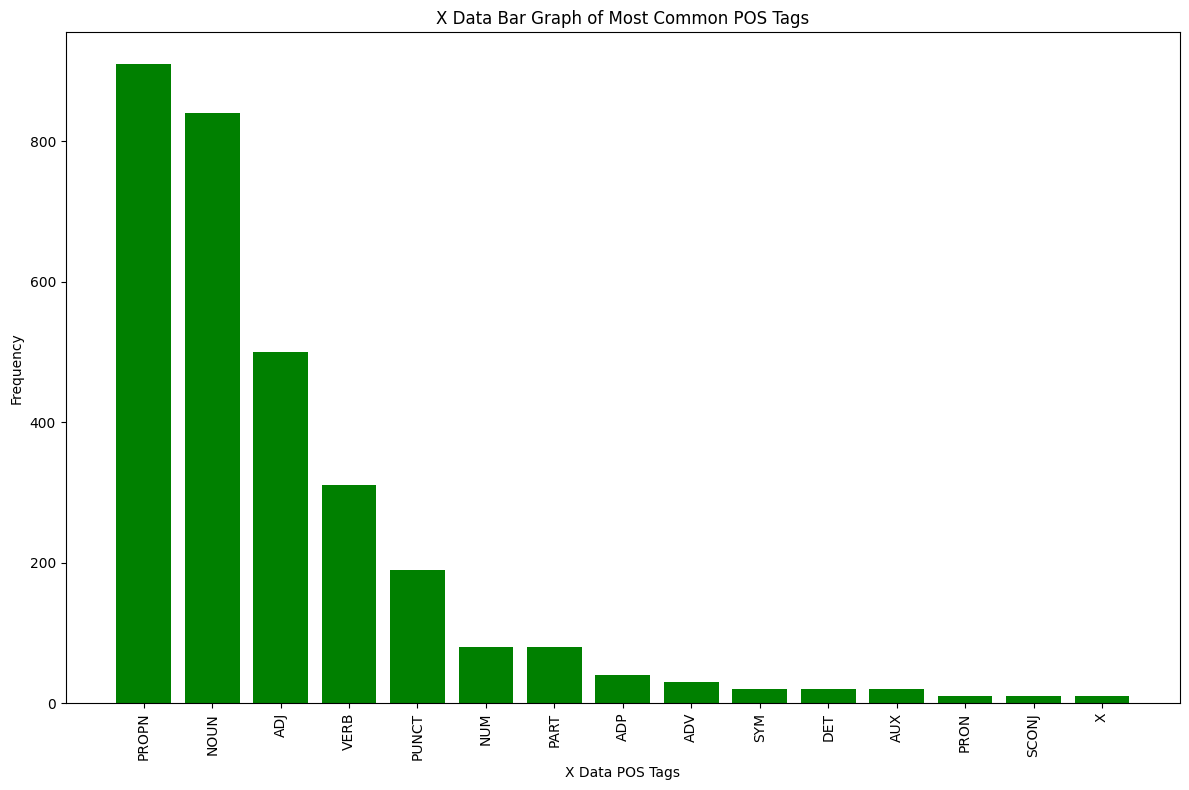

In [74]:
# Bar Chart

plt.figure(figsize=(12, 8))
plt.bar(pos_labels, pos_values, color='green')
plt.title('X Data Bar Graph of Most Common POS Tags')
plt.xlabel('X Data POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

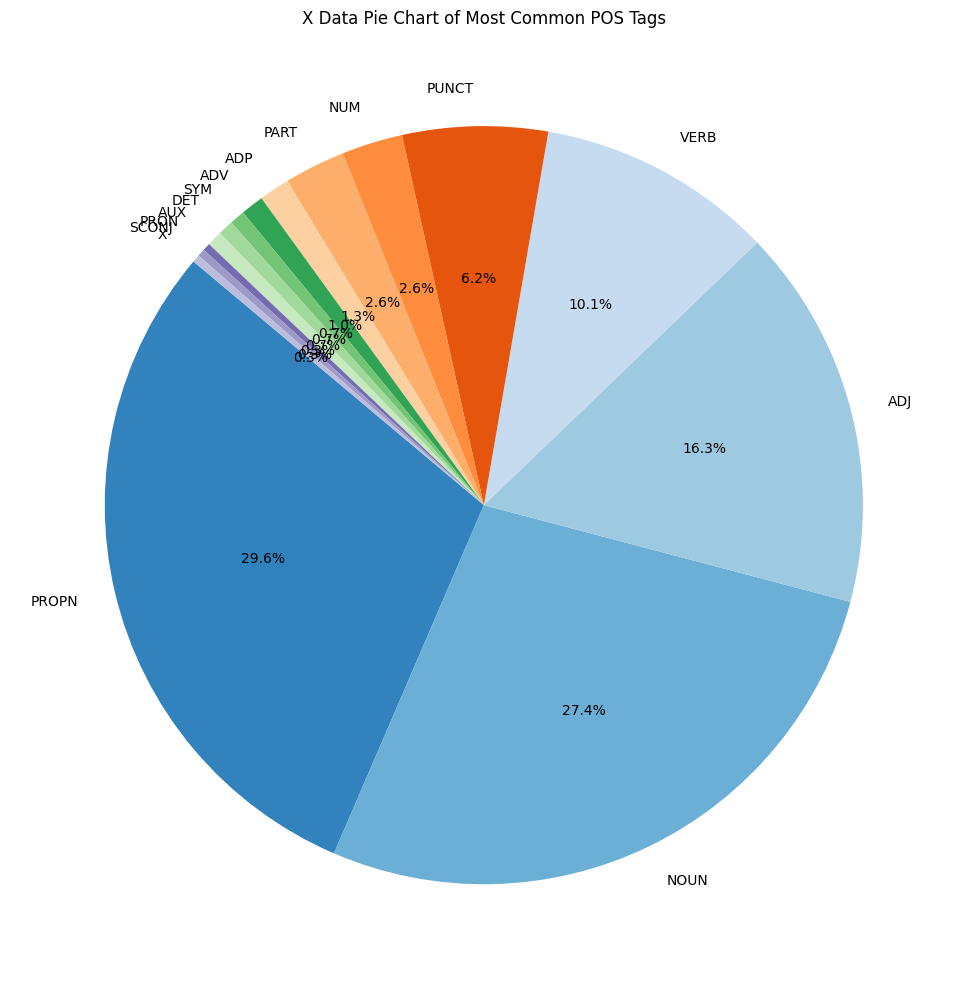

In [75]:
# Pie Chart

plt.figure(figsize=(10, 10))
plt.pie(pos_values, labels=pos_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20c.colors)
plt.title('X Data Pie Chart of Most Common POS Tags')
plt.tight_layout()
plt.show()

Visualizing Named Entities

Named Entity Label Counts:
TIME: 62
PERSON: 34
ORG: 46
MONEY: 1
CARDINAL: 34
NORP: 11
GPE: 36
DATE: 29
PRODUCT: 8
LOC: 5
WORK_OF_ART: 1
ORDINAL: 1


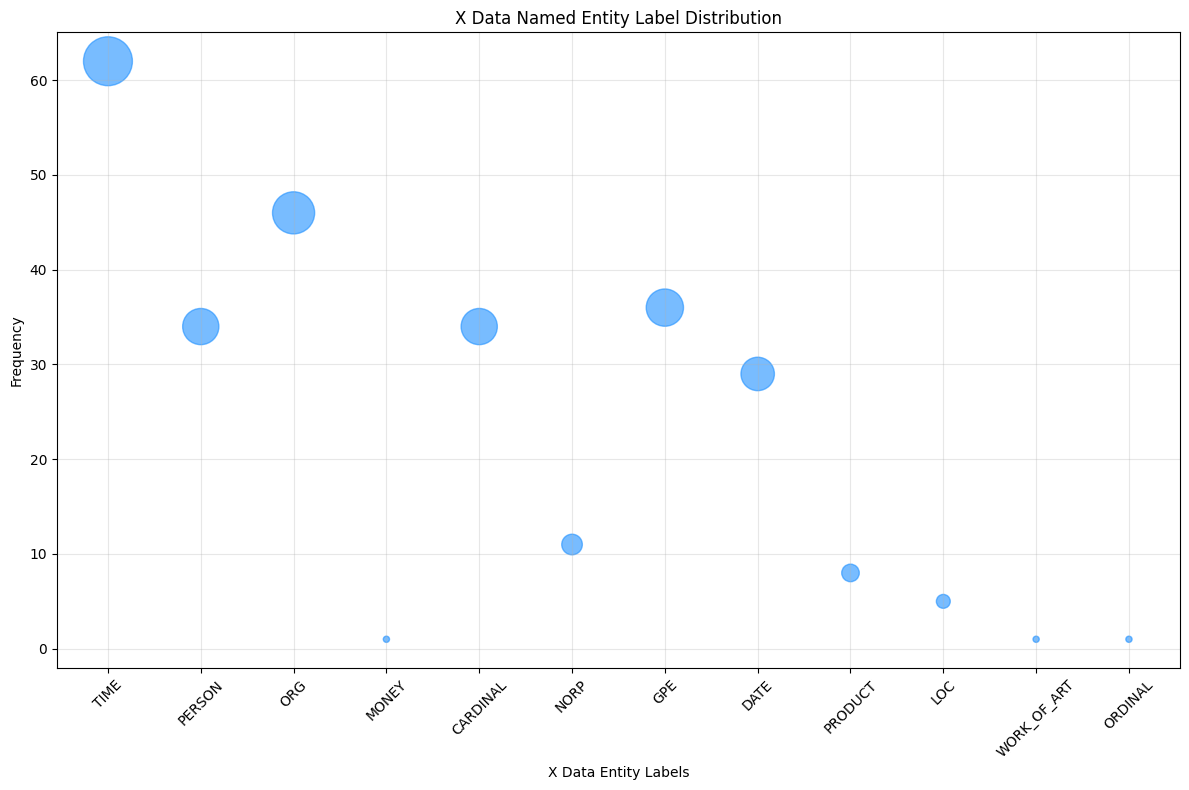

In [76]:
# Counting the frequency of each entity label

entity_labels = [label for _, label in entities]
entity_counts = Counter(entity_labels)

print("Named Entity Label Counts:")
for label, count in entity_counts.items():
    print(f"{label}: {count}")

# Preparing data for the scatter plot

labels = list(entity_counts.keys())
counts = list(entity_counts.values())

# Scatter Plot

plt.figure(figsize=(12, 8))
plt.scatter(labels, counts, color='dodgerblue', s=[count * 20 for count in counts], alpha=0.6)
plt.title('X Data Named Entity Label Distribution')
plt.xlabel('X Data Entity Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

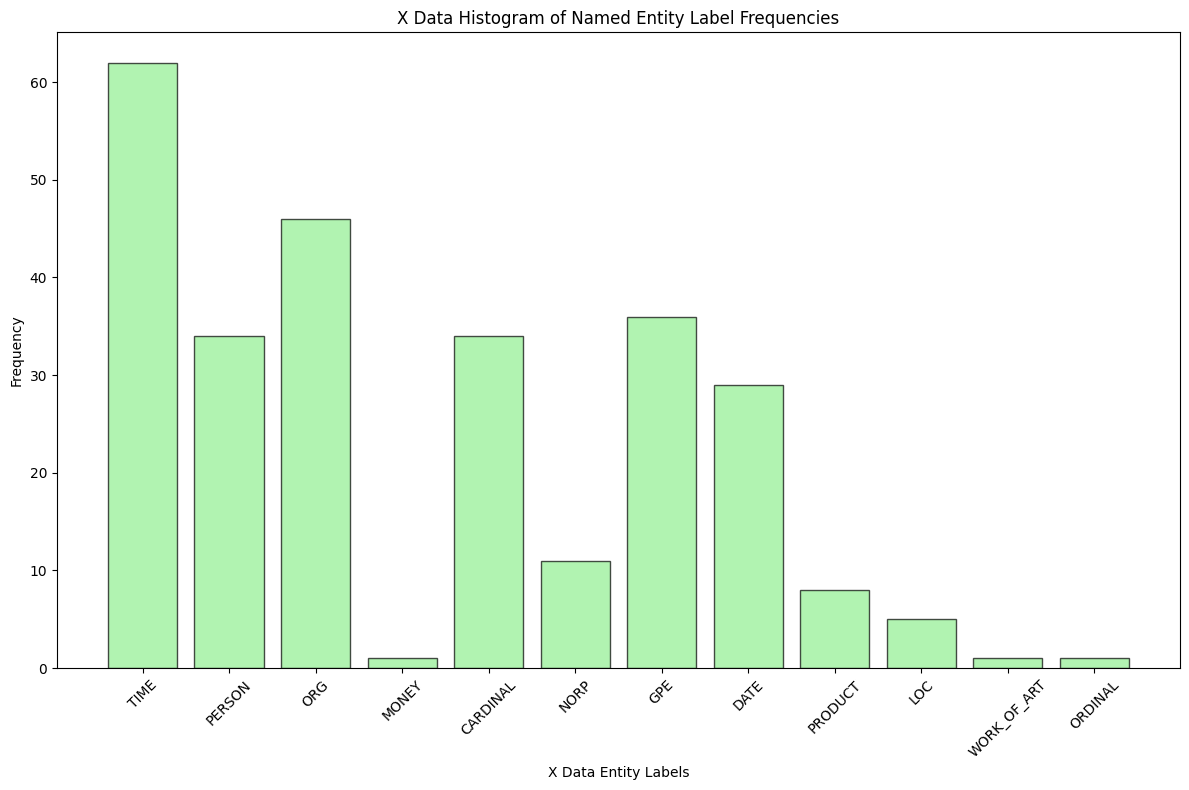

In [77]:
# Histogram

plt.figure(figsize=(12, 8))
plt.bar(labels, counts, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('X Data Histogram of Named Entity Label Frequencies')
plt.xlabel('X Data Entity Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### POS Tagging and NER 'preprocessed_reddit_posts_with_stemming.csv'


In [78]:
# Loading the dataset

reddit_file_path = '/content/preprocessed_reddit_posts_with_stemming.csv'
reddit_data = pd.read_csv(reddit_file_path)

# Extracting the processed text column

reddit_processed_titles = reddit_data['Processed Title'].apply(eval)  # Converting stringified list back to list

# Converting lists of tokens into sentences

reddit_sentences = [" ".join(tokens) for tokens in reddit_processed_titles]

# Initializing containers for POS tagging and NER results

reddit_pos_tags = []
reddit_entities = []

# Processing each sentence

for sentence in reddit_sentences:
    doc = nlp(sentence)

    # Extracting POS tags

    reddit_pos_tags.extend([(token.text, token.pos_) for token in doc])

    # Extracting named entities

    reddit_entities.extend([(ent.text, ent.label_) for ent in doc.ents])

# Counting the most common POS tags

reddit_pos_counts = Counter(tag for _, tag in reddit_pos_tags)

# Displaying POS Tagging Results

print("Most Common POS Tags:")
print(reddit_pos_counts.most_common())

# Displaying Named Entity Recognition Results

print("\nNamed Entities:")
print(reddit_entity_counts)

# Saving results to CSV files

reddit_pos_output_path = 'reddit_pos_results.csv'
reddit_ner_output_path = 'reddit_ner_results.csv'

# Saving POS tags

pd.DataFrame({
    'POS_Tag': [tag for tag, _ in reddit_pos_counts.most_common()],
    'Count': [count for _, count in reddit_pos_counts.most_common()]
}).to_csv(reddit_pos_output_path, index=False)

# Saving named entities

pd.DataFrame(reddit_entities, columns=['Entity', 'Label']).to_csv(reddit_ner_output_path, index=False)

print(f"Reddit POS tagging results saved to {reddit_pos_output_path}.")
print(f"Reddit NER results saved to {reddit_ner_output_path}.")

Most Common POS Tags:
[('PROPN', 910), ('NOUN', 840), ('ADJ', 500), ('VERB', 310), ('PUNCT', 190), ('NUM', 80), ('PART', 80), ('ADP', 40), ('ADV', 30), ('SYM', 20), ('DET', 20), ('AUX', 20), ('PRON', 10), ('SCONJ', 10), ('X', 10)]

Named Entities:
Counter({'GPE': 190, 'NORP': 120, 'PERSON': 110, 'DATE': 60, 'ORG': 60, 'CARDINAL': 40, 'LANGUAGE': 10, 'ORDINAL': 10})
Reddit POS tagging results saved to reddit_pos_results.csv.
Reddit NER results saved to reddit_ner_results.csv.


Visualizing Most Common POS Tags

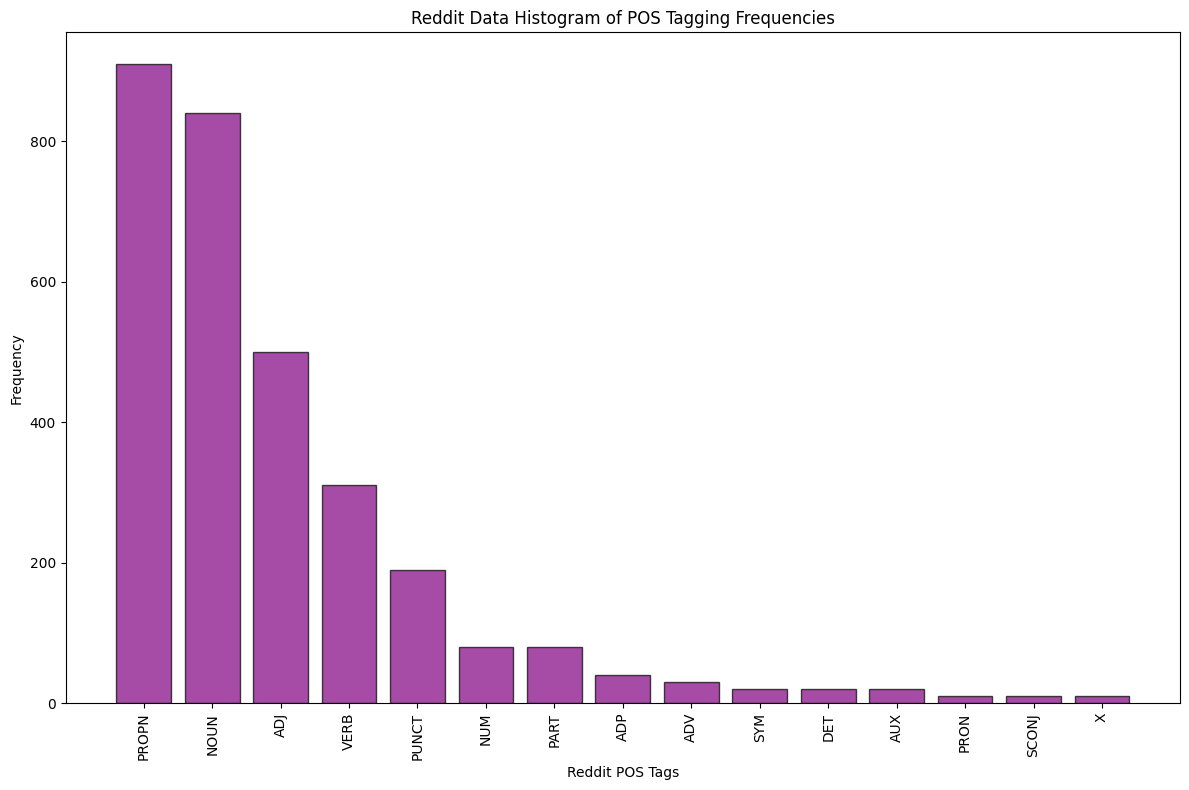

In [79]:
# Preparing data for visualization

pos_labels = [tag for tag, _ in reddit_pos_counts.most_common()]
pos_values = [count for _, count in reddit_pos_counts.most_common()]

# Histogram

plt.figure(figsize=(12, 8))
plt.bar(pos_labels, pos_values, color='purple', edgecolor='black', alpha=0.7)
plt.title('Reddit Data Histogram of POS Tagging Frequencies')
plt.xlabel('Reddit POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

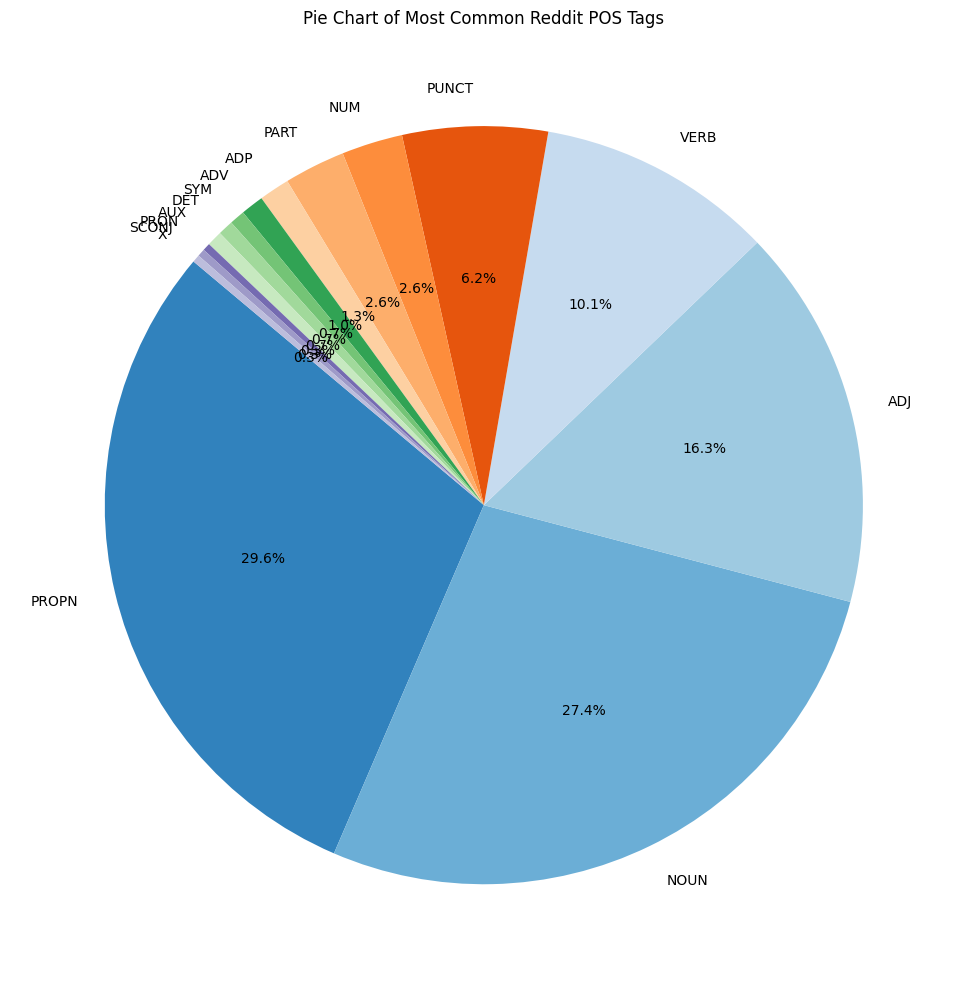

In [81]:
# Pie Chart

plt.figure(figsize=(10, 10))
plt.pie(pos_values, labels=pos_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20c.colors)
plt.title('Pie Chart of Most Common Reddit POS Tags')
plt.tight_layout()
plt.show()

Visualinzing Named Entities

In [82]:
# Counting the frequency of each named entity label

entity_labels = [label for _, label in reddit_entities]
entity_counts = Counter(entity_labels)

# Displaying Named Entity Counts

print("Named Entity Label Counts:")
for label, count in entity_counts.items():
    print(f"{label}: {count}")

# Preparing data for visualization

labels = list(entity_counts.keys())
counts = list(entity_counts.values())

Named Entity Label Counts:
NORP: 120
DATE: 60
CARDINAL: 40
GPE: 190
PERSON: 110
ORG: 60
LANGUAGE: 10
ORDINAL: 10


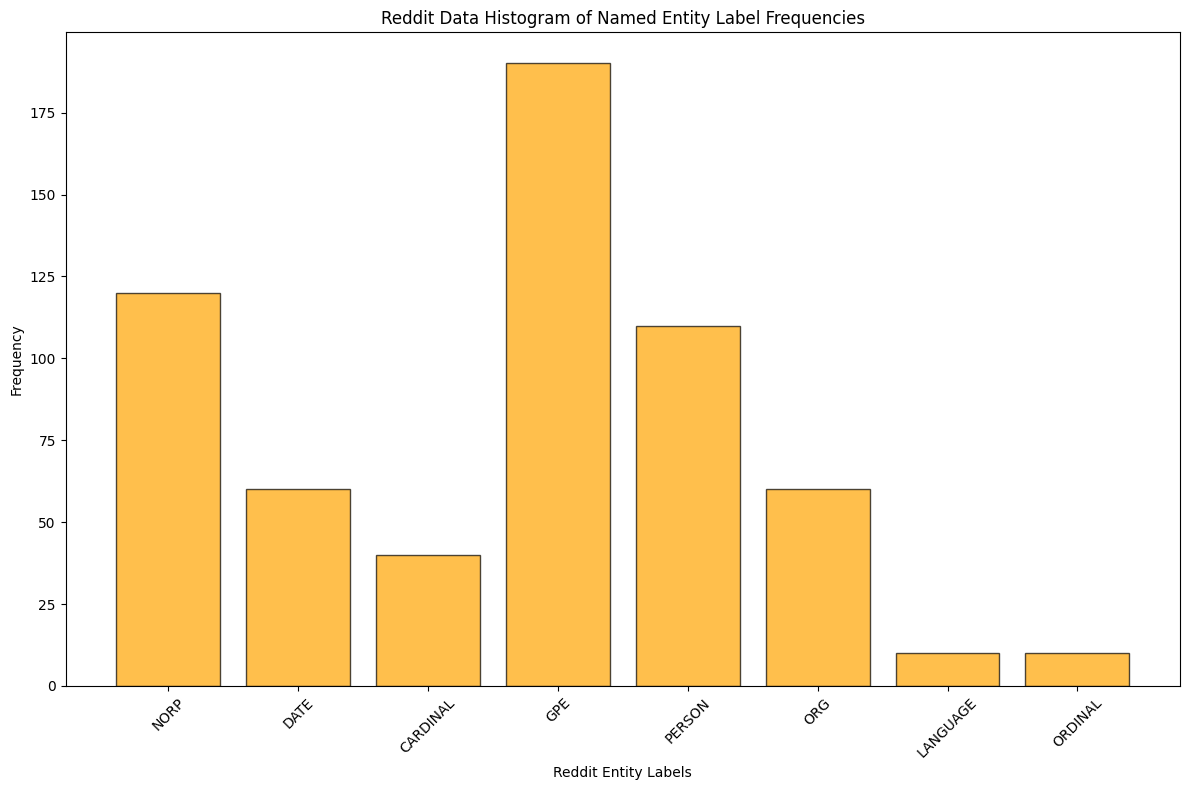

In [86]:
# Histogram

plt.figure(figsize=(12, 8))
plt.bar(labels, counts, color='orange', edgecolor='black', alpha=0.7)
plt.title('Reddit Data Histogram of Named Entity Label Frequencies')
plt.xlabel('Reddit Entity Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

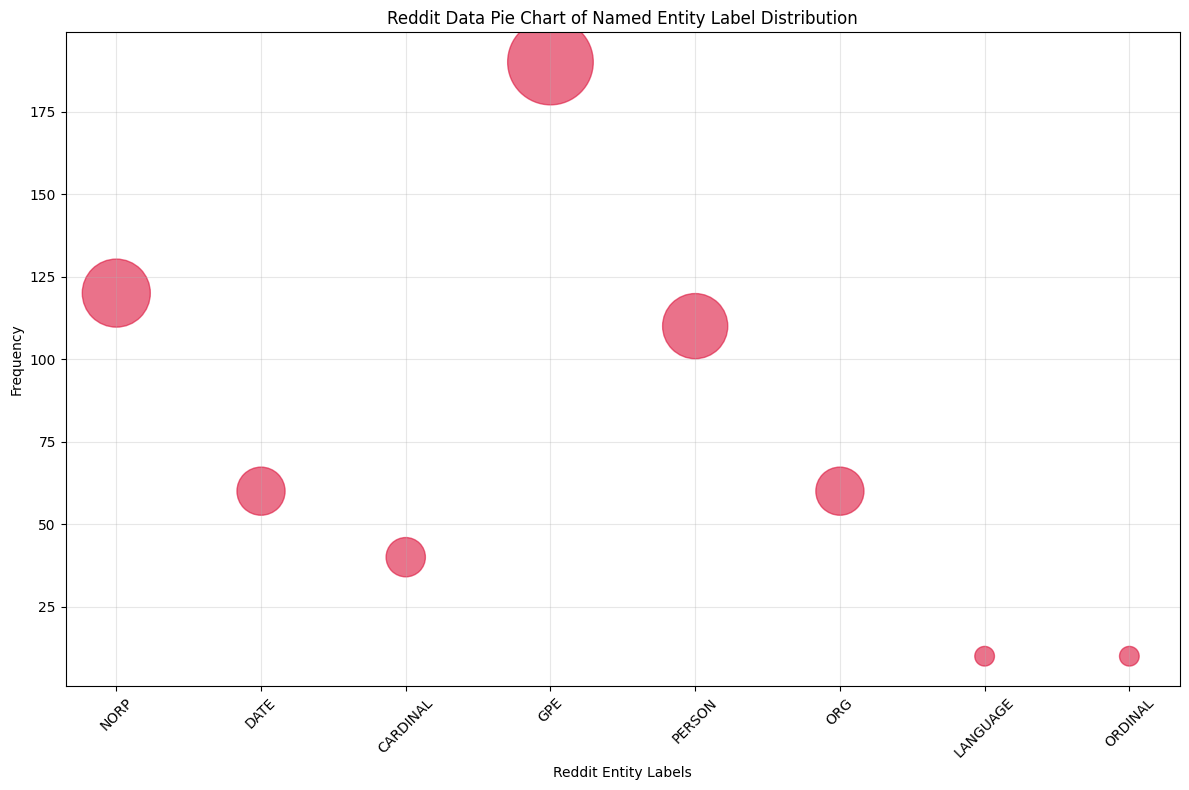

In [90]:
# Scatter Plot

plt.figure(figsize=(12, 8))
plt.scatter(labels, counts, color='crimson', s=[count * 20 for count in counts], alpha=0.6)
plt.title('Reddit Data Pie Chart of Named Entity Label Distribution')
plt.xlabel('Reddit Entity Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### POS Tagging and ENR 'preprocesseed_cleaned_worldnews_100_articles.csv'

In [92]:
# Loading the dataset

worldnews_file_path = '/content/preprocessed_cleaned_worldnews_100_articles.csv'
worldnews_data = pd.read_csv(worldnews_file_path)

# Extracting the processed text column

worldnews_processed_texts = worldnews_data['Processed Text'].apply(eval)  # Converting stringified list back to list

# Converting lists of tokens into sentences

worldnews_sentences = [" ".join(tokens) for tokens in worldnews_processed_texts]

# Initializing containers for POS tagging and NER results

worldnews_pos_tags = []
worldnews_entities = []

# Processing each sentence

for sentence in worldnews_sentences:
    doc = nlp(sentence)

    # Extracting POS tags

    worldnews_pos_tags.extend([(token.text, token.pos_) for token in doc])

    # Extracting named entities

    worldnews_entities.extend([(ent.text, ent.label_) for ent in doc.ents])

# Counting the most common POS tags
worldnews_pos_counts = Counter(tag for _, tag in worldnews_pos_tags)

# Displaying Results

print("Most Common POS Tags:")
print(worldnews_pos_counts.most_common())

print("\nNamed Entities:")
print(worldnews_entities)

# Saving results to CSV files

pos_output_path = 'news_articles_pos_results.csv'
ner_output_path = 'news_articles_ner_results.csv'

# Saving POS tags

pd.DataFrame({
    'POS_Tag': [tag for tag, _ in worldnews_pos_counts.most_common()],
    'Count': [count for _, count in worldnews_pos_counts.most_common()]
}).to_csv(pos_output_path, index=False)

# Saving named entities

pd.DataFrame(worldnews_entities, columns=['Entity', 'Label']).to_csv(ner_output_path, index=False)

print(f"POS tagging results saved to {pos_output_path}.")
print(f"NER results saved to {ner_output_path}.")

Most Common POS Tags:
[('NOUN', 667), ('PROPN', 408), ('VERB', 267), ('ADJ', 204), ('NUM', 135), ('PUNCT', 91), ('ADV', 45), ('ADP', 18), ('PRON', 13), ('AUX', 13), ('PART', 12), ('CCONJ', 6), ('DET', 4), ('X', 4), ('SYM', 3), ('INTJ', 2), ('SCONJ', 2)]

Named Entities:
[('fabio quartararo', 'PERSON'), ('2024', 'DATE'), ('3478', 'CARDINAL'), ('japanese', 'NORP'), ('donald trump', 'PERSON'), ('1', 'CARDINAL'), ('8269', 'CARDINAL'), ('south africa', 'GPE'), ('20171', 'CARDINAL'), ('smith chairliololliuk health alliance climate', 'ORG'), ('7896', 'DATE'), ('el secretario news', 'ORG'), ('swiss', 'NORP'), ('colombian', 'NORP'), ('591', 'CARDINAL'), ('damascus', 'GPE'), ('syria', 'GPE'), ('tuesday', 'DATE'), ('bashar alassad', 'PERSON'), ('french', 'NORP'), ('first', 'ORDINAL'), ('5340', 'CARDINAL'), ('past year', 'DATE'), ('5', 'CARDINAL'), ('first', 'ORDINAL'), ('2024', 'DATE'), ('6246', 'CARDINAL'), ('indian', 'NORP'), ('indian', 'NORP'), ('2953', 'CARDINAL'), ('7642', 'CARDINAL'), ('rus

Visualizing Most Common POS Tags

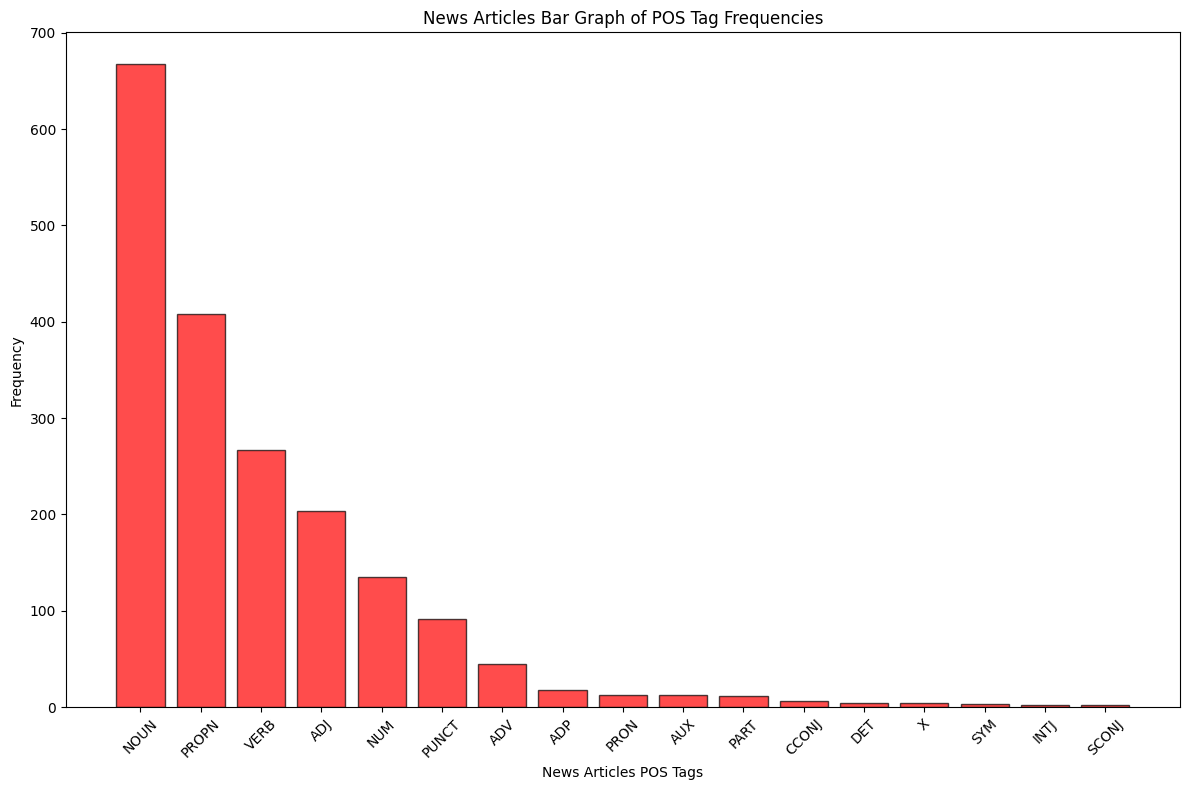

In [94]:
# Preparing data for visualization

pos_labels = [tag for tag, _ in worldnews_pos_counts.most_common()]
pos_values = [count for _, count in worldnews_pos_counts.most_common()]

# Bar Graph

plt.figure(figsize=(12, 8))
plt.bar(pos_labels, pos_values, color='red', edgecolor='black', alpha=0.7)
plt.title('News Articles Bar Graph of POS Tag Frequencies')
plt.xlabel('News Articles POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

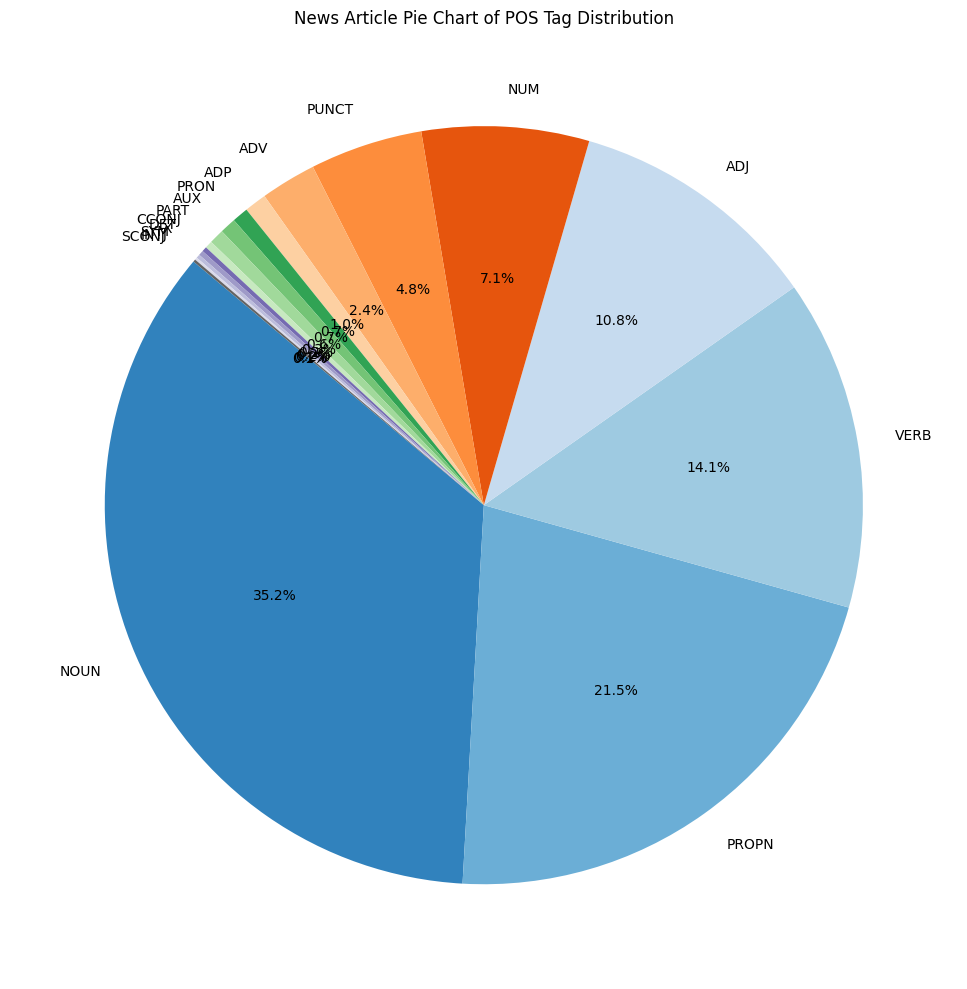

In [95]:
# Pie Chart

plt.figure(figsize=(10, 10))
plt.pie(pos_values, labels=pos_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20c.colors)
plt.title('News Article Pie Chart of POS Tag Distribution')
plt.tight_layout()
plt.show()

Visualizing Named Entities

In [96]:
# Counting the frequency of each named entity label

entity_labels = [label for _, label in worldnews_entities]
entity_counts = Counter(entity_labels)

# Displaying Named Entity Counts

print("Named Entity Label Counts:")
for label, count in entity_counts.items():
    print(f"{label}: {count}")

# Preparing data for visualization

labels = list(entity_counts.keys())
counts = list(entity_counts.values())

Named Entity Label Counts:
PERSON: 28
DATE: 82
CARDINAL: 81
NORP: 13
GPE: 38
ORG: 33
ORDINAL: 13
MONEY: 1
TIME: 3
LOC: 1
PRODUCT: 2


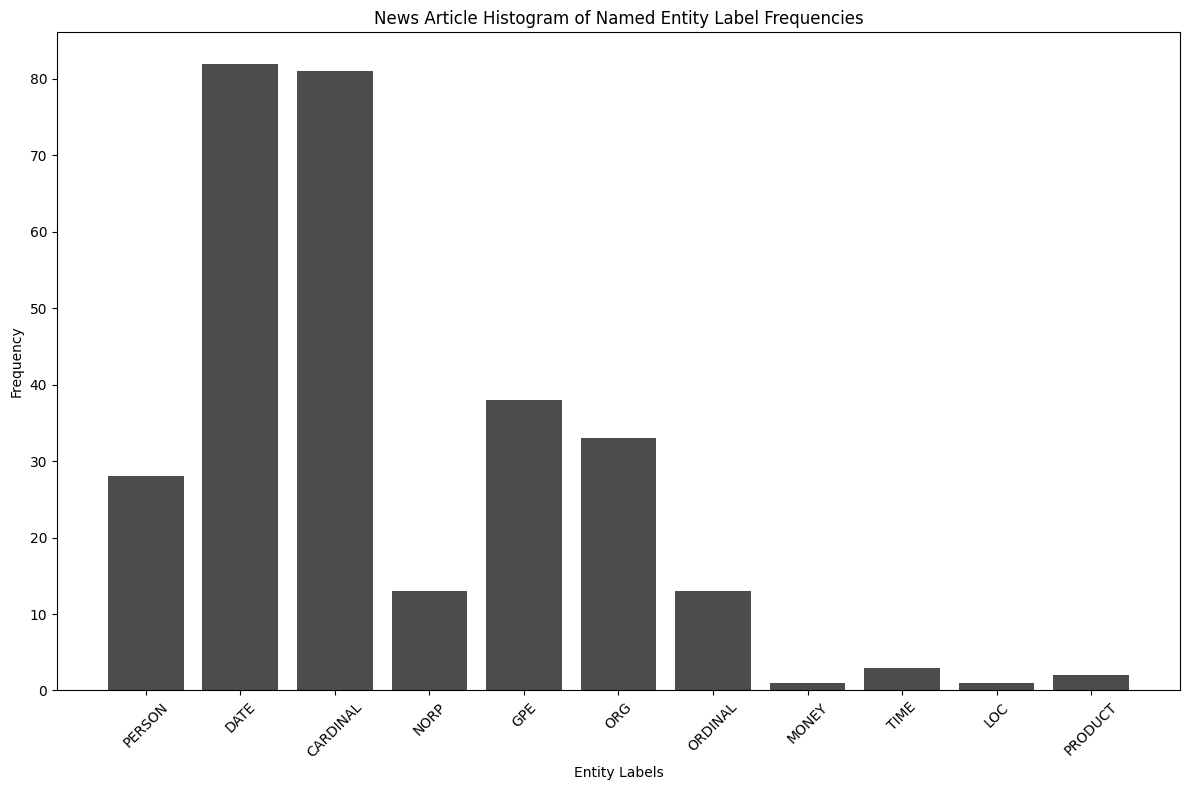

In [99]:
# Histogram
plt.figure(figsize=(12, 8))
plt.bar(labels, counts, color='black', alpha=0.7)
plt.title('News Article Histogram of Named Entity Label Frequencies')
plt.xlabel('Entity Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

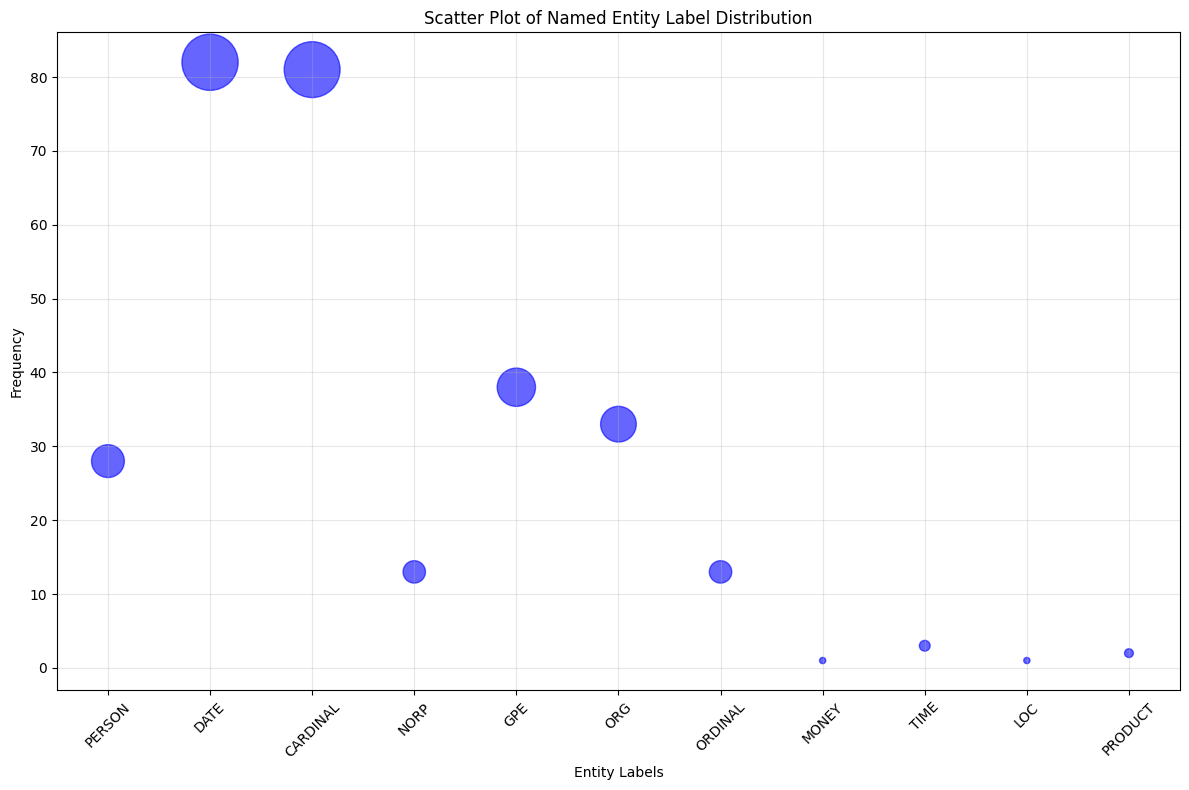

In [102]:
# Scatter Plot
plt.figure(figsize=(12, 8))
plt.scatter(labels, counts, color='blue', s=[count * 20 for count in counts], alpha=0.6)
plt.title('Scatter Plot of Named Entity Label Distribution')
plt.xlabel('Entity Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()